This notebook looks at the two extreme groups of types of plants ("less than 10"
and "greater than 30") to find the vioscreen variables that can tell the two groups apart the most. 

For each vioscreen variable, Mannwhitney U test was used to test for the difference between two extreme groups, and the corresponding Mannwhitney effect size was calculated. (reference: Fritz 2011, "Effect Size Estimates: Current Use, Calculations, and Interpretation).

Vioscreen variables with large effect size (greater than threshold 0.5) are selected to display in the boxplot. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import skbio
import scipy as sp
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
% matplotlib inline

## Subset of mapping file

In [2]:
mapping = pd.read_csv('ag_map_with_alpha.txt', sep='\t', dtype=str, na_values='Unspecified')

In [3]:
vioscreen_cols = [col for col in mapping.columns if 'vioscreen' in col]
vioscreen_cols.insert(0,"#SampleID")
vioscreen_cols.append('types_of_plants')
vioscreen_cols.append('shannon_1250')
vioscreen_cols.append('faiths_pd_1250')
vios = mapping.loc[:, mapping.columns.isin(vioscreen_cols)]
vios.set_index('#SampleID', inplace=True)

In [4]:
def cast_to_numeric(x):
    return float(x)

non_numeric = []
for col in vios.columns:
    # Try to make the column a number using the cast_to_numeric function
    try:
        vios[col] = vios[col].apply(cast_to_numeric)
    # If that doesn't work, add the column name to the non-numeric list
    except:
        non_numeric.append(col)
        
vios_sub = vios.loc[pd.isnull(vios['vioscreen_database']) == False]

In [5]:
# keep only 'types_of_plants' in the non_numeric
vios_sub.drop(non_numeric[1:12], axis='columns', inplace=True)

vios_sub = vios_sub[vios_sub['types_of_plants'].isin (['Less than 5','6 to 10','More than 30'])]

In [6]:
# write data to output file
vios_sub.to_csv('viscreen_subsample_mapping.txt', sep='\t')

## Analysis on the subset of mapping file

In [8]:
mapping = pd.read_csv('viscreen_subsample_mapping.txt', sep='\t', dtype={'#SampleID': str})

In [9]:
mapping['types_of_plants'].value_counts()

6 to 10         185
More than 30    146
Less than 5      58
Name: types_of_plants, dtype: int64

In [10]:
mapping.head()

,#SampleID,types_of_plants,vioscreen_add_sug,vioscreen_a_bev,vioscreen_a_cal,vioscreen_alcohol_servings,vioscreen_calcium_avg,vioscreen_calcium_dose,vioscreen_calcium_from_dairy_servings,vioscreen_calcium_servings,...,vioscreen_vitd3,vioscreen_vitd_iu,vioscreen_vite_iu,vioscreen_vitk,vioscreen_water,vioscreen_wgrain,vioscreen_xylitol,vioscreen_zinc,faiths_pd_1250,shannon_1250
0,10317.000040165,More than 30,7.435480,0.369342,49.404987,0.36934,NaN,NaN,2.22721,3.67901,...,4.558630,182.384663,19.309343,221.659485,3198.077148,3.229288,0.054877,10.327617,9.375266,3.817933
1,10317.000037976,6 to 10,18.021753,1.183890,150.368713,1.18389,NaN,500.0,5.03471,6.88337,...,18.107042,724.423065,17.807974,129.981659,4189.851562,1.379754,0.017808,17.632055,13.258567,5.127982
2,10317.000023595,More than 30,4.937973,2.351836,293.934082,2.35184,NaN,NaN,1.54063,3.88244,...,7.487753,299.510136,15.058907,658.501343,5351.371094,2.504027,0.057178,14.126797,10.183612,3.027013
3,10317.000058877,6 to 10,3.203671,2.062876,304.104553,2.06288,NaN,NaN,0.83230,1.96849,...,3.828575,153.181372,19.110027,182.761383,2078.856689,0.098027,0.032000,6.276904,17.436974,5.572705
4,10317.000044384,Less than 5,14.182713,0.000000,0.000000,0.00000,285.0,500.0,1.42734,2.62849,...,3.521698,140.897532,17.172411,107.054573,3332.181885,1.294301,0.035014,11.438876,19.586808,6.537345


In [11]:
# use only numerical viosreen variables (exclude 'SampleID', 'faith_pd_1250' and 'shannon_1250')
vioscreen_cols = mapping.columns[2: 249] 

In [12]:
# collapse three types of plants into two
def binary_types(x):
    if (x == 'More than 30'):
        return('More than 30')
    else:
        return('Less than 10')
mapping['types'] = mapping['types_of_plants'].apply(binary_types)

In [13]:
mapping['types'].value_counts()

Less than 10    243
More than 30    146
Name: types, dtype: int64

In [14]:
less = mapping.loc[mapping['types'] == 'Less than 10']
more = mapping.loc[mapping['types'] == 'More than 30']

In [15]:
print(less.shape)
print(more.shape)

(243, 252)
(146, 252)


In [16]:
# mannwhitney u tests between two extreme plant groups
results = []
for var in vioscreen_cols:
    if np.sum(mapping[var]) != 0:
        u, pval = sp.stats.mannwhitneyu(less[var], more[var], alternative = 'two-sided')  
        ef = np.absolute(sp.stats.ranksums(less[var], more[var])[0]/np.sqrt(mapping.shape[0]))
        results.append([var, u, pval, ef])   

In [17]:
results = pd.DataFrame(results, columns=['vioscreen var', 'mannwhitney u', 'mannwhitney pval', 'effect size'])

In [18]:
# pvalue after BH and Beonferrroni correction
from statsmodels.sandbox.stats.multicomp import multipletests
results['fdr corrected pval'] = multipletests(results['mannwhitney pval'], method = 'fdr_bh')[1]
results['bf corrected pval'] = multipletests(results['mannwhitney pval'], method = 'bonferroni')[1]

In [19]:
results = results.sort_values(['effect size'], ascending=False)
results.head(10)

,vioscreen var,mannwhitney u,mannwhitney pval,effect size,fdr corrected pval,bf corrected pval
169,vioscreen_pectins,5876.0,2.259805e-28,0.560142,3.486909e-26,5.468729e-26
77,vioscreen_veg5_day,5959.0,5.283208e-28,0.556223,4.261787e-26,1.278536e-25
86,vioscreen_vegetable_servings,6000.5,2.881743e-28,0.554264,3.486909e-26,6.973819e-26
101,vioscreen_betacar,6157.0,4.026882e-27,0.546874,2.436264e-25,9.745055e-25
85,vioscreen_v_total,6333.0,2.362768e-26,0.538564,1.143580e-24,5.717898e-24
226,vioscreen_vita_iu,6352.0,2.855550e-26,0.537667,1.151739e-24,6.910431e-24
78,vioscreen_vegsumm,6382.0,3.816453e-26,0.536250,1.319402e-24,9.235817e-24
237,vioscreen_vitk,6499.0,1.223529e-25,0.530726,3.701175e-24,2.960940e-23
144,vioscreen_lutzeax,6565.0,2.337268e-25,0.527610,6.284653e-24,5.656187e-23
123,vioscreen_fibinso,6679.0,7.086117e-25,0.522227,1.714840e-23,1.714840e-22


In [20]:
# significant variables
results_ef = results.loc[results['effect size'] >= 0.5]
results_ef = results_ef.sort_values(['effect size'], ascending=False)
vars_ef = np.array(results_ef['vioscreen var'])

In [21]:
# select interested variables
vars_select = np.append(vars_ef, ['vioscreen_pfa182', 'vioscreen_totcla'])

## boxplot for normalized data

In [22]:
# normalize vioscreen cols
mapping_norm = mapping.copy()
mapping_norm[vioscreen_cols] = mapping_norm[vioscreen_cols].apply(lambda x: x / (x.sum()))
mapping_norm = mapping_norm.loc[:, mapping_norm.columns.isin(np.append('types', vars_select))]

In [23]:
mapping_norm.shape

(389, 18)

In [24]:
mapping_norm_long = pd.melt(mapping_norm, id_vars='types', value_vars=vars_select)

In [25]:
mapping_norm_long.head()

,types,variable,value
0,More than 30,vioscreen_pectins,0.002799
1,Less than 10,vioscreen_pectins,0.001788
2,More than 30,vioscreen_pectins,0.003276
3,Less than 10,vioscreen_pectins,0.002709
4,Less than 10,vioscreen_pectins,0.002175


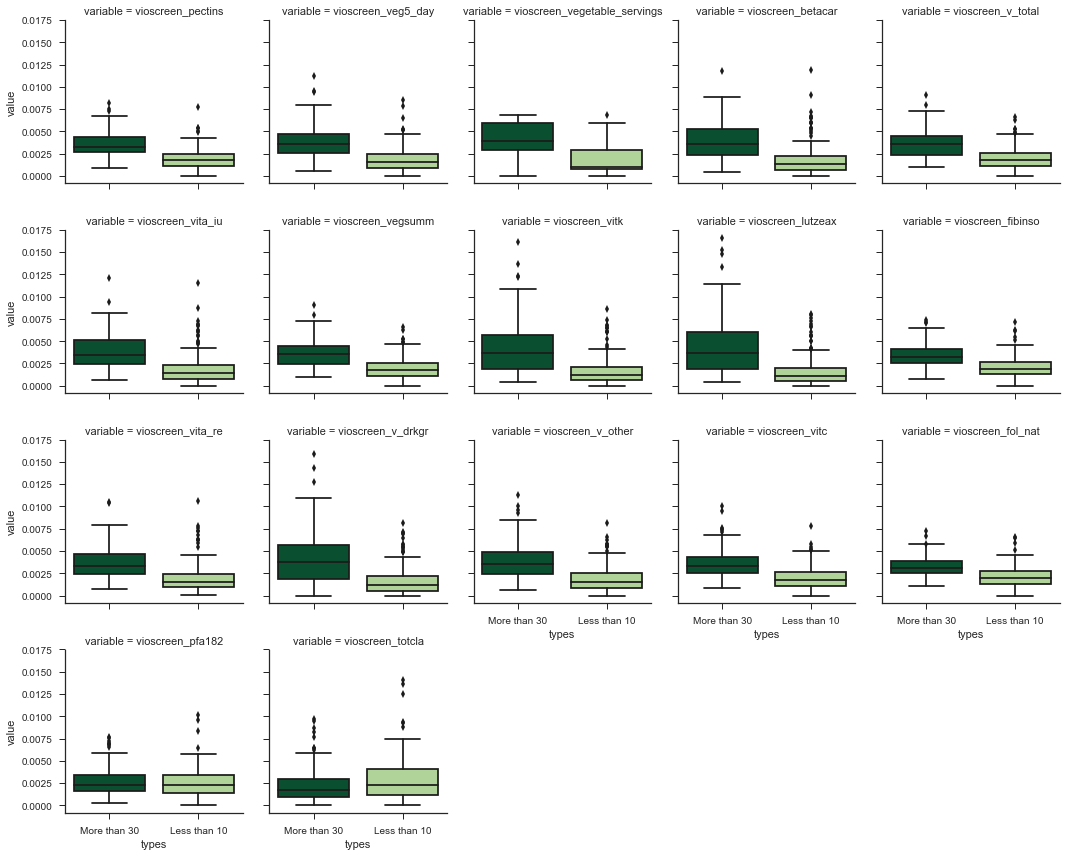

In [26]:
sns.set_style('ticks')
fig = sns.FacetGrid(mapping_norm_long, col="variable", col_wrap=5)
fig.map(sns.boxplot, 'types', 'value', palette=['#005a32', '#addd8e'])
fig.savefig('vioscreen_boxplot_updated_facetGrid.pdf')

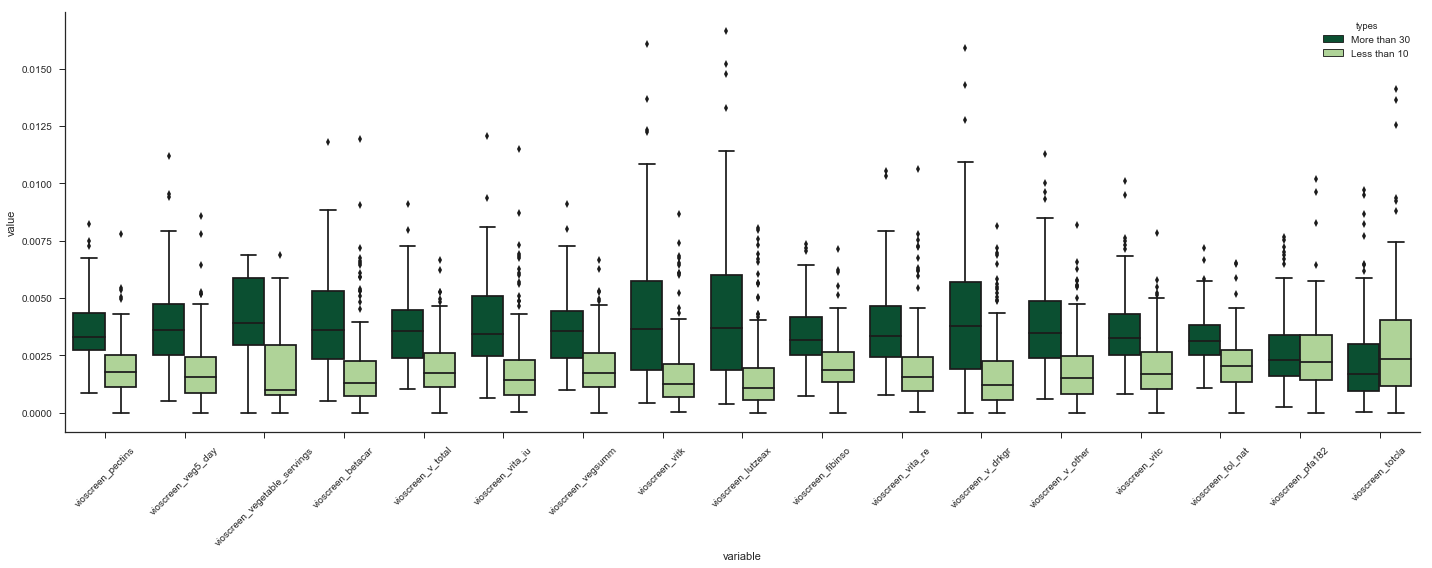

In [27]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)

fig = sns.boxplot(x = 'variable', y = 'value', data=mapping_norm_long, hue='types', palette=['#005a32', '#addd8e'])
fig.set_xticklabels(ax.get_xticklabels(), rotation=45)
sns.despine()

# tight_layout
fig = fig.get_figure()
fig.tight_layout()
fig.savefig('vioscreen_boxplot_updated.pdf')